# Predicting Lending Club's issued loans using Deep Learning with TensorFlow and Keras


The dataset includes comprehensive loan information for all loans issued between 2007 and 2015, encompassing current loan status (such as Current, Late, Fully Paid, etc.) and the latest payment details. The file with data up to the 'present' provides complete loan information through the most recent completed calendar quarter. Additional features in the dataset include credit scores, number of financial inquiries, address details (including zip codes and state), and collections, among others.

The objective is to predict the loan status as either Good or Bad. The analysis is performed using TensorFlow and Keras in Python.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline 
import logging
import tensorflow as tf

In [2]:
#Importing the dataset
dataset = pd.read_csv("lc_loan.csv",low_memory=False)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

In [4]:
dataset = dataset[:100000]

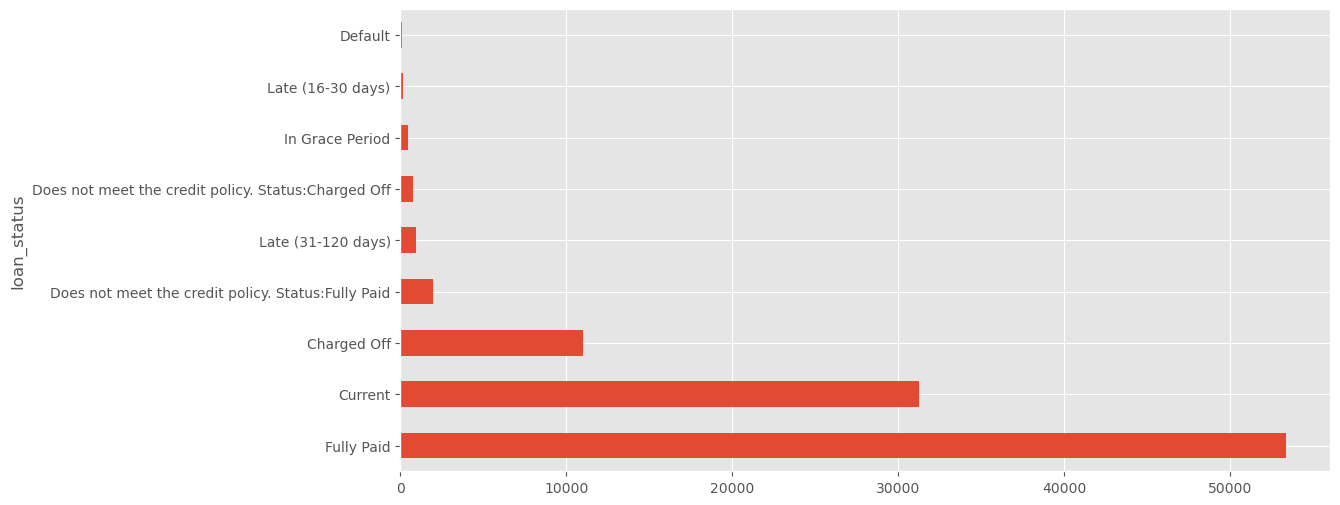

In [5]:
# Plotted Loan Status
plt.figure(figsize= (12,6))
plt.ylabel('Loan Status')
plt.xlabel('Count')
dataset['loan_status'].value_counts().plot(kind = 'barh', grid = True)
plt.show()

The target variable exhibits a slightly skewed distribution, with a higher proportion of observations in the Fully Paid category.

Following a thorough examination of the available feature variables, we will remove some of them based on the following criteria: they may be time-series variables (such as dates or months), lack variability in distribution, or have a predominance of zero values.

In [6]:
# Drop these features for now
dataset.drop([    'id',
             'member_id',
             'emp_title',
             'title',
             'url',
             'zip_code',
             'issue_d',# time-series data, expands model dimension for more than 100
             'pymnt_plan',#Same value
             'earliest_cr_line',
             'out_prncp', 
             'out_prncp_inv',
             'total_rec_late_fee',
             'recoveries', 
             'collection_recovery_fee',
             'last_pymnt_d',
             'next_pymnt_d',
             'desc',
             'last_credit_pull_d',
             'collections_12_mths_ex_med',
             'policy_code',
             'application_type',
             'acc_now_delinq',
             'tot_coll_amt',
             'tot_cur_bal'], axis=1, inplace=True)

In [7]:
# Show records number
dataset.count().sort_values()

inq_last_12m                        0
annual_inc_joint                    0
dti_joint                           0
verification_status_joint           0
open_acc_6m                         0
open_il_6m                          0
open_il_12m                         0
total_cu_tl                         0
mths_since_rcnt_il                  0
open_il_24m                         0
il_util                             0
open_rv_12m                         0
open_rv_24m                         0
max_bal_bc                          0
all_util                            0
inq_fi                              0
total_bal_il                        0
mths_since_last_record          10851
mths_since_last_major_derog     12309
mths_since_last_delinq          41922
total_rev_hi_lim                57465
emp_length                      96254
revol_util                      99874
total_acc                       99971
pub_rec                         99971
open_acc                        99971
inq_last_6mt

In [8]:
# Dropping columns with less than 25% data

threshold = 0.25 * len(dataset)  # 25% of the total rows
lack_of_data_cols = [col for col in dataset.columns if dataset[col].count() < threshold]
dataset.drop(lack_of_data_cols, axis=1, inplace=True)

# Display the remaining columns and record counts

dataset.count().sort_values()

mths_since_last_delinq     41922
total_rev_hi_lim           57465
emp_length                 96254
revol_util                 99874
total_acc                  99971
pub_rec                    99971
open_acc                   99971
inq_last_6mths             99971
delinq_2yrs                99971
annual_inc                 99996
total_rec_int             100000
total_rec_prncp           100000
total_pymnt_inv           100000
total_pymnt               100000
initial_list_status       100000
revol_bal                 100000
loan_amnt                 100000
addr_state                100000
purpose                   100000
loan_status               100000
verification_status       100000
home_ownership            100000
sub_grade                 100000
grade                     100000
installment               100000
int_rate                  100000
term                      100000
funded_amnt_inv           100000
funded_amnt               100000
last_pymnt_amnt           100000
dti       

In [9]:
# After Deletion
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   loan_amnt               100000 non-null  float64
 1   funded_amnt             100000 non-null  float64
 2   funded_amnt_inv         100000 non-null  float64
 3   term                    100000 non-null  object 
 4   int_rate                100000 non-null  float64
 5   installment             100000 non-null  float64
 6   grade                   100000 non-null  object 
 7   sub_grade               100000 non-null  object 
 8   emp_length              96254 non-null   object 
 9   home_ownership          100000 non-null  object 
 10  annual_inc              99996 non-null   float64
 11  verification_status     100000 non-null  object 
 12  loan_status             100000 non-null  object 
 13  purpose                 100000 non-null  object 
 14  addr_state           

In [10]:
dataset.dropna(inplace=True)

Renaming some features to concur with some algorithms

In [11]:
#Rename some features to concur with some algorithms,

dataset = dataset.rename(columns= {'emp_length_< 1 year':'emp_length_lt_1 year',
                         'emp_length_n/a':'emp_length_na'})

Preparing the target features
There are many classes in loan_status feature. However, lets divide it into 3 classses:

1) bad
2) warning
3) safe

In [12]:

bad_index = ['Charged Off',
             'Does not meet the credit policy. Status:Charged Off',
             'Default'
             ]

warning_index = ['Late (31-120 days)',
                 'Late (16-30 days)',
                 'In Grace Period'          # (Late (1-15 days)
                 ]

safe_index = ['Fully Paid',
              'Does not meet the credit policy. Status:Fully Paid'
              ]

In [13]:
def func(x):
    if x['loan_status'] in bad_index:
        return 0
    elif x['loan_status'] in warning_index:
        return 1
    else:
        return 2

dataset['loan_status_coded'] = dataset.apply(func, axis=1)
dataset.drop('loan_status', axis=1, inplace=True)

Thus our new target variable for predictions is loan_status_coded

## Feature Engineering with Exploratory Data Analysis

After pre-processing data, let's explore distribution of some relevant features to understand data.

loan_amnt:
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


/var/folders/ly/3ktmx9r518bgzqtk_9ptvvvc0000gn/T/ipykernel_63532/3273030844.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset["loan_amnt"])
/Users/aashayzende/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='loan_amnt', ylabel='Density'>

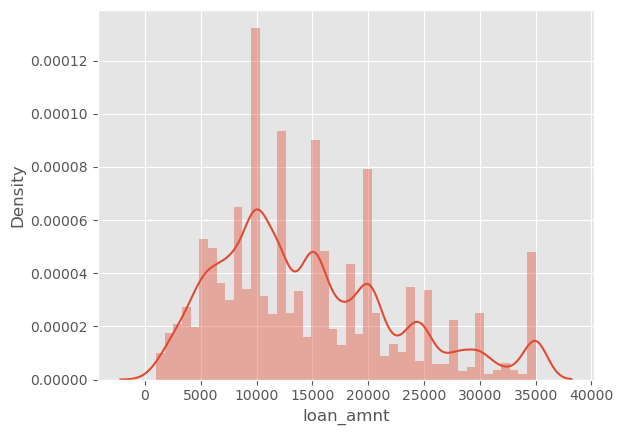

In [14]:
sns.distplot(dataset["loan_amnt"])

funded_amnt: The total amount committed to that loan at that point in time.
funded_amnt_inv: The total amount committed by investors for that loan at that point in time.

/var/folders/ly/3ktmx9r518bgzqtk_9ptvvvc0000gn/T/ipykernel_63532/3156446879.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset["funded_amnt"], label="funded_amnt")
/Users/aashayzende/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/ly/3ktmx9r518bgzqtk_9ptvvvc0000gn/T/ipykernel_63532/3156446879.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your co

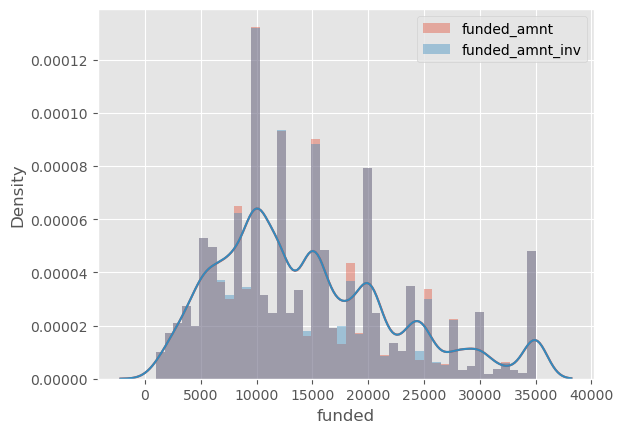

In [15]:
plt.figure()
sns.distplot(dataset["funded_amnt"], label="funded_amnt")
sns.distplot(dataset["funded_amnt_inv"], label="funded_amnt_inv")
plt.legend()
plt.xlabel("funded")
plt.show()

term: The number of payments on the loan. Values are in months and can be either 36 or 60.

int_rate: Interest Rate on the loan

/var/folders/ly/3ktmx9r518bgzqtk_9ptvvvc0000gn/T/ipykernel_63532/3543568839.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset["int_rate"])
/Users/aashayzende/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='int_rate', ylabel='Density'>

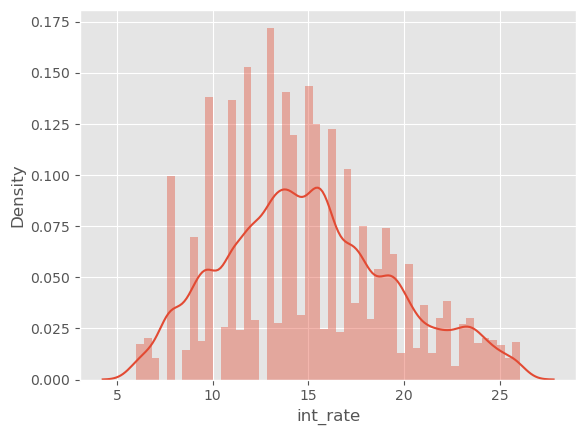

In [16]:
sns.distplot(dataset["int_rate"])

installment: The monthly payment owed by the borrower if the loan originates.

/var/folders/ly/3ktmx9r518bgzqtk_9ptvvvc0000gn/T/ipykernel_63532/1193062530.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset["installment"])
/Users/aashayzende/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='installment', ylabel='Density'>

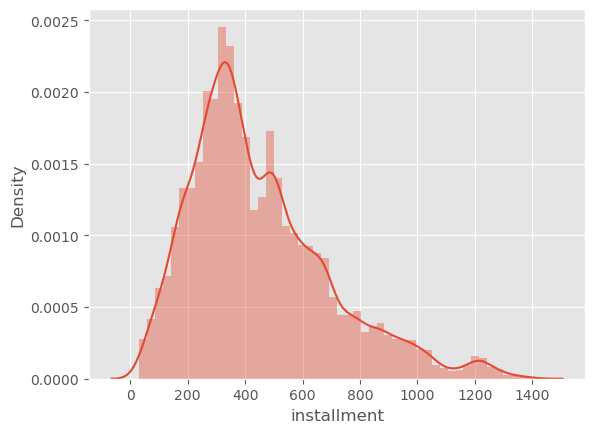

In [17]:
sns.distplot(dataset["installment"])

annual_inc: The self-reported annual income provided by the borrower during registration.

We can see that annual_inc is heavily skewed with outlier.

/var/folders/ly/3ktmx9r518bgzqtk_9ptvvvc0000gn/T/ipykernel_63532/1784820143.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset["annual_inc"], bins=200)
/Users/aashayzende/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 300000.0)

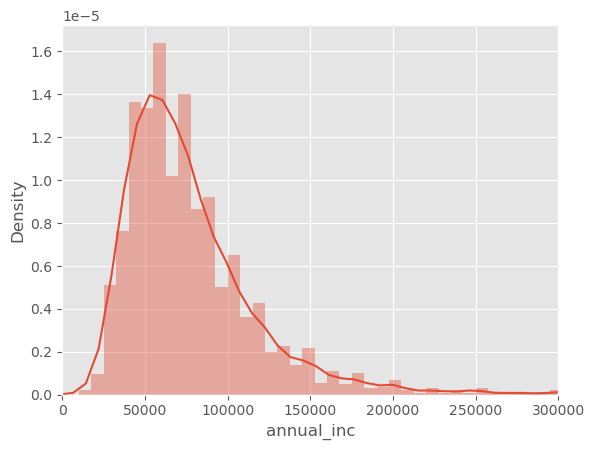

In [18]:
sns.distplot(dataset["annual_inc"], bins=200)
plt.xlim(0,300000)

purpose: A category provided by the borrower for the loan request.

In [19]:
dataset.purpose.value_counts()

purpose
debt_consolidation    15398
credit_card            5863
home_improvement       1315
other                  1200
major_purchase          389
small_business          272
medical                 200
car                     158
moving                  118
vacation                103
house                    91
wedding                  45
renewable_energy          9
Name: count, dtype: int64

purpose: A category provided by the borrower for the loan request.

<Axes: xlabel='count', ylabel='purpose'>

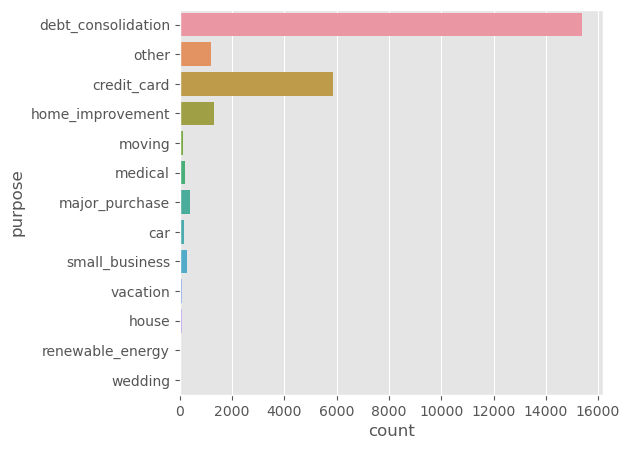

In [21]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(y=dataset["purpose"])

total_rec_prncp: Principal received to date

total_rec_int: Interest received to date

total_rec_late_fee: Late fees received to date

/var/folders/ly/3ktmx9r518bgzqtk_9ptvvvc0000gn/T/ipykernel_63532/208367975.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.total_rec_prncp)
/Users/aashayzende/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='total_rec_prncp', ylabel='Density'>

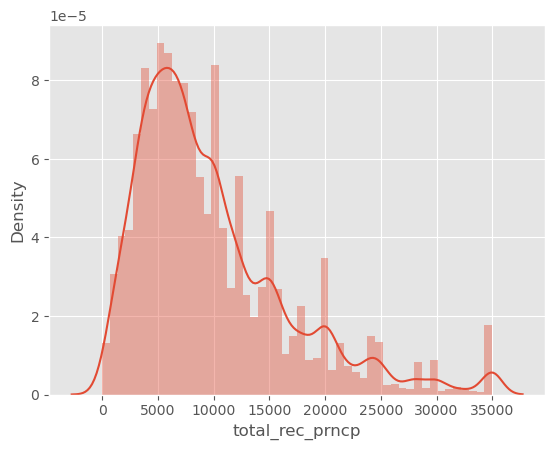

In [22]:
sns.distplot(dataset.total_rec_prncp)

/var/folders/ly/3ktmx9r518bgzqtk_9ptvvvc0000gn/T/ipykernel_63532/805859604.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.total_rec_int)
/Users/aashayzende/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='total_rec_int', ylabel='Density'>

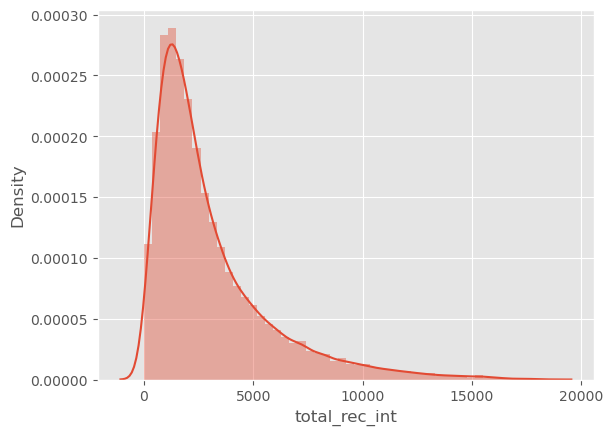

In [23]:
sns.distplot(dataset.total_rec_int)

last_pymnt_amnt: Last total payment amount received

/var/folders/ly/3ktmx9r518bgzqtk_9ptvvvc0000gn/T/ipykernel_63532/3678532958.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.last_pymnt_amnt)
/Users/aashayzende/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='last_pymnt_amnt', ylabel='Density'>

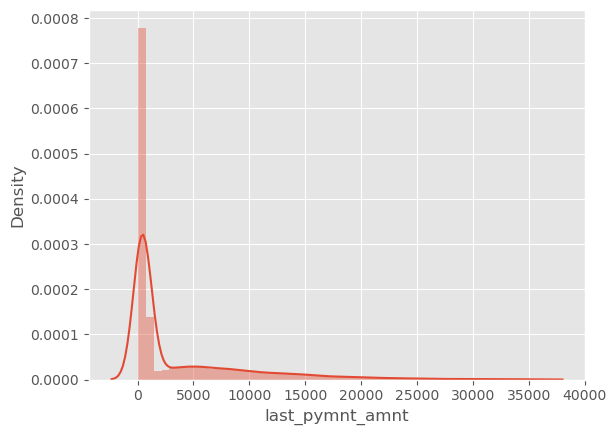

In [24]:
sns.distplot(dataset.last_pymnt_amnt)

In [25]:
dataset.select_dtypes(include=['int','float','object','bool']).dtypes


loan_amnt                 float64
funded_amnt               float64
funded_amnt_inv           float64
term                       object
int_rate                  float64
installment               float64
grade                      object
sub_grade                  object
emp_length                 object
home_ownership             object
annual_inc                float64
verification_status        object
purpose                    object
addr_state                 object
dti                       float64
delinq_2yrs               float64
inq_last_6mths            float64
mths_since_last_delinq    float64
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                float64
total_acc                 float64
initial_list_status        object
total_pymnt               float64
total_pymnt_inv           float64
total_rec_prncp           float64
total_rec_int             float64
last_pymnt_amnt           float64
total_rev_hi_l

One-hot Encoding
So far, we have confirmed that there are several categorical features. Let's define features and categorical features






In [26]:
features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
            'installment', 'grade', 'emp_length', 'home_ownership',
            'annual_inc', 'verification_status', 'purpose', 'dti',
            'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util',
            'total_acc', 'initial_list_status', 'total_pymnt', 'total_pymnt_inv',
            'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt',
            'total_rev_hi_lim', 'loan_status_coded']
categorical = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
               'purpose', 'initial_list_status']
dataset = dataset[features]

One-hot encoding is done using the get_dummies from pandas

In [27]:
categorical_variables = categorical
dataset_one_hot_encoded = pd.get_dummies(dataset, columns=categorical_variables)
print("Data Types")
print(dataset_one_hot_encoded.dtypes[:60])

Data Types
loan_amnt                              float64
funded_amnt                            float64
funded_amnt_inv                        float64
int_rate                               float64
installment                            float64
annual_inc                             float64
dti                                    float64
delinq_2yrs                            float64
inq_last_6mths                         float64
open_acc                               float64
revol_bal                              float64
revol_util                             float64
total_acc                              float64
total_pymnt                            float64
total_pymnt_inv                        float64
total_rec_prncp                        float64
total_rec_int                          float64
last_pymnt_amnt                        float64
total_rev_hi_lim                       float64
loan_status_coded                        int64
term_ 36 months                           bool
te

Now split the dataset into training and testing sets



In [28]:
from sklearn.model_selection import train_test_split
# Train-Test split
y = dataset_one_hot_encoded.loan_status_coded
X = dataset_one_hot_encoded.drop("loan_status_coded", axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [29]:
print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_train:  (20128, 60)
Shape of y_train:  (20128,)
Shape of x_test:  (5033, 60)
Shape of y_test:  (5033,)


## Building the Deep Learning model


Lets now build a model for training using the well-known Keras library with a Tensorflow backend.

In [30]:
from keras import utils as np_utils
from sklearn.preprocessing import LabelEncoder

def encode_neural_net_y(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    new_y = np_utils.to_categorical(encoded_y)
    return new_y

# Neural Network model
y_train = encode_neural_net_y(y_train)
y_test = encode_neural_net_y(y_test)

Let's use a 2-layer fully connected neural network with 35 neurons in the hidden layer. 
We will insert a batch normalization layer between the hidden layer and the output layer. The loss function will be categorical crossentropy, and the optimization method will be ADAM. The activation function for the input layers will be ReLU, while the output layer will use Softmax

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization

# create model
model = Sequential()
model.add(Dense(35, input_dim=60, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

/Users/aashayzende/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 35)             │         2,135 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 35)             │           140 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           108 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,383 (9.31 KB)

 Trainable params: 2,313 (9.04 KB)

 Non-trainable params: 70 (280.00 B)

In [33]:
model.fit(x_train, y_train, epochs=30, batch_size=40, verbose=1)

Epoch 1/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step - acc: 0.7828 - loss: 0.6857
Epoch 2/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - acc: 0.9320 - loss: 0.2357
Epoch 3/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - acc: 0.9369 - loss: 0.2192
Epoch 4/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - acc: 0.9414 - loss: 0.2062
Epoch 5/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - acc: 0.9435 - loss: 0.2072
Epoch 6/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - acc: 0.9484 - loss: 0.1881
Epoch 7/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - acc: 0.9469 - loss: 0.1947
Epoch 8/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - acc: 0.9563 - loss: 0.1681
Epoch 9/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - acc: 0.9511 - loss: 0.1786
Epoch 10/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - acc: 0.9527 - loss: 0.1742
Epoch 11/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - acc: 0.9433 - loss: 0.1949
Epoch 12/30
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - acc: 0.9390 - loss: 0.2054
E

## Model Evaluation

Lets now observe the test and training set accuracies.

In [34]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("====================[TEST SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

====================[TEST SCORE]====================
compile_metrics: 96.62%


In [35]:
scores = model.evaluate(x_train, y_train, verbose=0)
print("====================[TRAIN SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

====================[TRAIN SCORE]====================
compile_metrics: 96.52%


Both training and test accuracies are excellent, indicating no signs of overfitting.

## Concluding Remarks

The Neural Network model, trained with relevant features, achieved an accuracy of 96.5% on the test data.

The model demonstrates low bias and low variance, as evidenced by its strong performance on both training and test datasets.

Implementing binary classification by encoding the target feature could potentially increase accuracy by at least 3-4%.

Additionally, the impact of incorporating regularization should be assessed.